In [1]:
import numpy as np
import tensorflow as tf

/Users/gurkan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
batch_size = 90
img_height = 180
img_width = 180
train_data_dir = "datasets/train/"
test_data_dir = "datasets/test/"
val_data_dir = "datasets/val/"

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary')

class_names = train_ds.class_names
print("Class:", class_names)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Class: ['NORMAL', 'PNEUMONIA']


2024-03-19 20:13:48.549192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


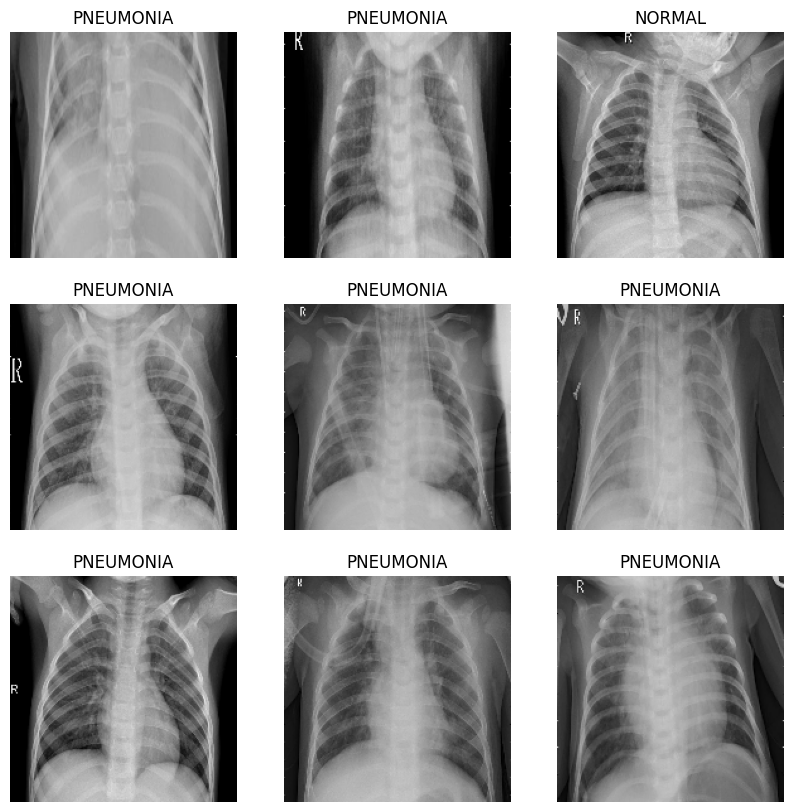

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary')

class_names = val_ds.class_names
print("Class:", class_names)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Class: ['NORMAL', 'PNEUMONIA']


In [69]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [71]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [72]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [73]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step - accuracy: 0.7011 - loss: 0.6009 - val_accuracy: 0.7766 - val_loss: 0.4845
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 402ms/step - accuracy: 0.8150 - loss: 0.3949 - val_accuracy: 0.9300 - val_loss: 0.1982
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.9173 - loss: 0.1951 - val_accuracy: 0.9521 - val_loss: 0.1434
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.9411 - loss: 0.1509 - val_accuracy: 0.9588 - val_loss: 0.1175
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.9474 - loss: 0.1204 - val_accuracy: 0.9722 - val_loss: 0.0853
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.9656 - loss: 0.0871 - val_accuracy: 0.9703 - val_loss: 0.0831
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.9654 - loss: 0.0813 - val_accuracy: 0.9741 - val_loss: 0.0773
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.9721 - loss: 0.0704 - val_accu

In [87]:
model.save('model_tf.keras')

In [6]:
model = tf.keras.models.load_model('./model_tf.keras')

In [7]:
loss, accuracy = model.evaluate(val_ds)
print("Validation accuracy: {:.2f} %".format(100 * accuracy))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9785 - loss: 0.0701
Validation accuracy: 97.51 %


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary')

class_names = test_ds.class_names
print("Class:", class_names)

Found 624 files belonging to 2 classes.
Using 124 files for validation.
Class: ['NORMAL', 'PNEUMONIA']


In [9]:
test_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
predictions = model.predict(test_ds)
scores = tf.nn.softmax(predictions)

avg_score = np.mean([np.max(score) for score in scores])
print("Average confidence score for all predictions: {:.2f} %".format(100 * avg_score))

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step
Average confidence score for all predictions: 97.06 %


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  validation_split=0.8,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary')

class_names = val_ds.class_names
print("Class:", class_names)

Found 16 files belonging to 2 classes.
Using 12 files for validation.
Class: ['NORMAL', 'PNEUMONIA']


In [12]:
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
predictions = model.predict(val_ds)
scores = tf.nn.softmax(predictions)

avg_score = np.mean([np.max(score) for score in scores])
print("Average confidence score for all predictions: {:.2f} %".format(100 * avg_score))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Average confidence score for all predictions: 89.69 %
